# Model comparison

## Model

We again consider the sine model with gaussian measurement errors.

$$ y = A_1 \sin\left(2 \pi \left(\frac{t}{P_1} + t_1\right)\right) + B + \epsilon $$

where $\epsilon \sim \mathrm{Normal}(0, \sigma)$

We want to test if this is preferred over pure noise.


In [1]:
import numpy as np
from numpy import pi, sin

def sine_model1(t, B, A1, P1, t1):
    return A1 * sin((t / P1 + t1) * 2 * pi) + B

def sine_model0(t, B):
    return B + t*0


The model has four unknown parameters per component:

* the signal offset $B$
* the amplitude $A$
* the period $P$
* the time offset $t_0$

## Generating data

Lets generate some data following this model:


In [2]:
np.random.seed(42)

n_data = 50

# time of observations
t = np.random.uniform(0, 5, size=n_data)
# measurement values
yerr = 1.0
y = np.random.normal(sine_model1(t, B=1.0, A1=0.9, P1=3, t1=0), yerr)


## Visualise the data

Lets plot the data first to see what is going on:

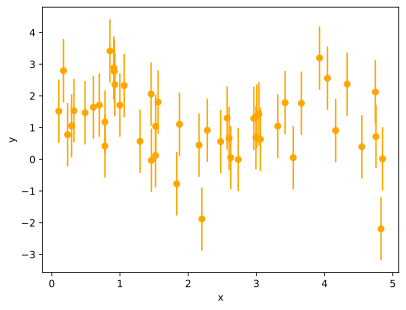

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange')
t_range = np.linspace(0, 5, 1000)


A beautiful noisy data set, with some hints of a modulation.

Now the question is: what model parameters are allowed under these data?

First, we need to define the parameter ranges through a prior:

In [4]:
parameters1 = ['B', 'A1', 'P1', 't1']

def prior_transform1(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    params = cube.copy()
    # let background level go from -10 to +10
    params[0] = cube[0] * 20 - 10
    # let amplitude go from 0.1 to 100
    params[1] = 10**(cube[1] * 3 - 1)
    # let period go from 0.3 to 30
    params[2] = 10**(cube[2] * 2)
    # let time go from 0 to 1
    params[3] = cube[3]
    return params

parameters0 = ['B']

def prior_transform0(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    params = cube.copy()
    # let background level go from -10 to +10
    params[0] = cube[0] * 20 - 10
    return params


Define the likelihood, which measures how far the data are from the model predictions.
More precisely, how often the parameters would arise under the given parameters.
We assume gaussian measurement errors of known size (yerr).

$$\chi^2 = \sum\left(\frac{m_i-y_i}{\sigma}\right)^2 $$
$$\log \cal{L} = -\chi^2 / 2$$

where the model is the sine_model function from above at time $t_i$.

In [5]:
def log_likelihood1(params):
    # unpack the current parameters:
    B, A1, P1, t1 = params

    # compute for each x point, where it should lie in y
    y_model = sine_model1(t, B=B, A1=A1, P1=P1, t1=t1)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()
    
    return loglike

def log_likelihood0(params):
    B, = params
    
    y_model = sine_model0(t, B=B)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()
    
    return loglike
    

Solve the problem:

In [6]:
import ultranest

sampler1 = ultranest.ReactiveNestedSampler(parameters1, log_likelihood1, prior_transform1)

sampler0 = ultranest.ReactiveNestedSampler(parameters0, log_likelihood0, prior_transform0)


In [7]:
result1 = sampler1.run(min_num_live_points=400)
sampler1.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 177973


[ultranest]   logZ = -32.7 +- 0.1201


[ultranest] Effective samples strategy satisfied (ESS = 2385.8, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.24, need <0.5)


[ultranest]   logZ error budget: single: 0.16 bs:0.12 tail:0.01 total:0.12 required:<0.50


[ultranest] done iterating.



logZ = -32.722 +- 0.238
  single instance: logZ = -32.722 +- 0.156
  bootstrapped   : logZ = -32.698 +- 0.238
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    B                   1.02 +- 0.26
    A1                  0.89 +- 0.31
    P1                  3.7 +- 6.1
    t1                  0.48 +- 0.45


In [8]:
result0 = sampler0.run(min_num_live_points=400)
sampler0.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01  


[ultranest] Likelihood function evaluations: 3470


[ultranest]   logZ = -35.87 +- 0.07029


[ultranest] Effective samples strategy satisfied (ESS = 1243.0, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)


[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.04 total:0.08 required:<0.50


[ultranest] done iterating.



logZ = -35.885 +- 0.162
  single instance: logZ = -35.885 +- 0.096
  bootstrapped   : logZ = -35.868 +- 0.157
  tail           : logZ = +- 0.038
insert order U test : converged: True correlation: inf iterations

    B                   1.15 +- 0.14


## Plot the parameter posterior probability distribution

A classic corner plot of the parameter pairs and the marginal distributions:

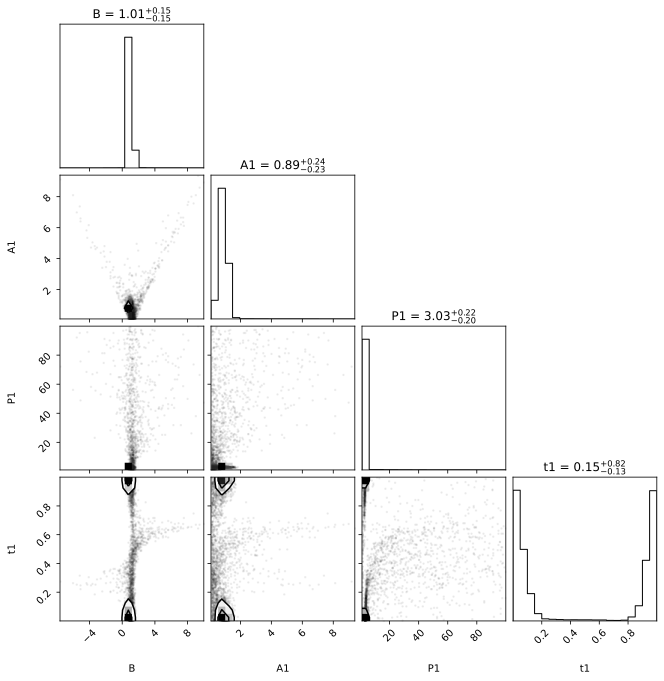

In [9]:
from ultranest.plot import cornerplot
cornerplot(result1)

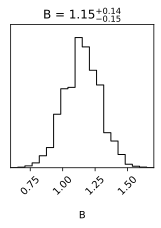

In [10]:
cornerplot(result0)

If you want, you can also play with the posterior as a pandas frame:

In [11]:
import pandas as pd
df = pd.DataFrame(data=result1['samples'], columns=result1['paramnames'])
df.describe()

,B,A1,P1,t1
count,7065.000000,7065.000000,7065.000000,7065.000000
mean,1.016814,0.892815,3.734001,0.475235
std,0.260352,0.309381,6.088507,0.445044
min,-3.337517,0.101084,1.010937,0.000062
25%,0.901084,0.730872,2.899282,0.042637
50%,1.008328,0.885560,3.032814,0.151977
75%,1.114300,1.051549,3.175849,0.957797
max,7.390607,6.467284,98.302179,0.999996


## Plot the fit:

To evaluate whether the results make any sense, we want
to look whether the fitted function goes through the data points.

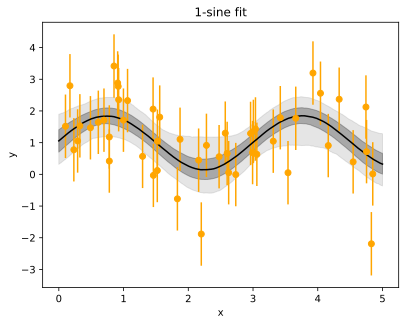

In [12]:
plt.figure()
plt.title("1-sine fit")
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange')


t_grid = np.linspace(0, 5, 400)

from ultranest.plot import PredictionBand
band = PredictionBand(t_grid)

# go through the solutions
for B, A1, P1, t1 in sampler1.results['samples']:
    # compute for each time the y value
    band.add(sine_model1(t_grid, B=B, A1=A1, P1=P1, t1=t1))

band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)







## Model comparison methods

We now want to know:

**Is the model with 2 components better than the model with one component?**

What do we mean by "better" ("it fits better", "the component is significant")?

a) Which model is better at predicting data it has not seen yet?

b) Which model is more probably the true one, given this data, these models, and their parameter spaces?

c) Which model is simplest, but complex enough to capture the information complexity of the data?


## Bayesian model comparison

Here we will focus on b, and apply Bayesian model comparison. 

For simplicity, we will assume equal a-prior model probabilities.

The Bayes factor is:


In [13]:
K = np.exp(result1['logz'] - result0['logz'])
print("K = %.2f" % K)
print("The 1-sine model is %.2f times more probable than the no-signal model" % K)
print("assuming the models are equally probable a priori.")

K = 23.66
The 1-sine model is 23.66 times more probable than the no-signal model
assuming the models are equally probable a priori.


N.B.: Bayes factors are influenced by parameter and model priors. It is a good idea to vary them and see how sensitive the result is.

For making decisions, thresholds are needed. They can be calibrated to desired low false decisions rates with simulations (generate data under the simpler model, look at K distribution).

## Calibrating Bayes factor thresholds

Lets generate some data sets under the null hypothesis (noise-only model) and see 
how often we would get a large Bayes factor. For this, we need to fit with both 
models.

In [14]:
import logging
logging.getLogger('ultranest').setLevel(logging.FATAL)

In [15]:
K_simulated = []

import logging
logging.getLogger('ultranest').handlers[-1].setLevel(logging.FATAL)

# go through 100 plausible parameters
for B in sampler0.results['samples'][:10]:
    # generate new data
    y = np.random.normal(sine_model0(t, B=1.0), yerr)
    
    # analyse with sine model
    sampler1 = ultranest.ReactiveNestedSampler(parameters1, log_likelihood1, prior_transform1)
    Z1 = sampler1.run(viz_callback=False)['logz']
    # analyse with noise-only model
    sampler0 = ultranest.ReactiveNestedSampler(parameters0, log_likelihood0, prior_transform0)
    Z0 = sampler0.run(viz_callback=False)['logz']
    # store Bayes factor
    K_here = Z1 - Z0
    K_simulated.append(K_here)
    print()
    print("Bayes factor: %.2f" % np.exp(K_here))


/home/user/Downloads/UltraNest/ultranest/integrator.py:1601: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)



Bayes factor: 0.24



Bayes factor: 0.26


/home/user/Downloads/UltraNest/ultranest/integrator.py:1601: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)



Bayes factor: 0.90


/home/user/Downloads/UltraNest/ultranest/integrator.py:1601: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)



Bayes factor: 0.40


/home/user/Downloads/UltraNest/ultranest/integrator.py:1601: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)



Bayes factor: 0.31


/home/user/Downloads/UltraNest/ultranest/integrator.py:1601: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)



Bayes factor: 0.21


/home/user/Downloads/UltraNest/ultranest/integrator.py:1601: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)



Bayes factor: 0.38


/home/user/Downloads/UltraNest/ultranest/integrator.py:1601: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)



Bayes factor: 0.30


/home/user/Downloads/UltraNest/ultranest/integrator.py:1601: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)



Bayes factor: 0.73


/home/user/Downloads/UltraNest/ultranest/integrator.py:1601: UserWarning: Sampling from region seems inefficient (0/40 accepted in iteration 2500). To improve efficiency, modify the transformation so that the current live points are ellipsoidal, or use a stepsampler, or set frac_remain to a lower number (e.g., 0.5) to terminate earlier.
  warnings.warn(warning_message)



Bayes factor: 0.44


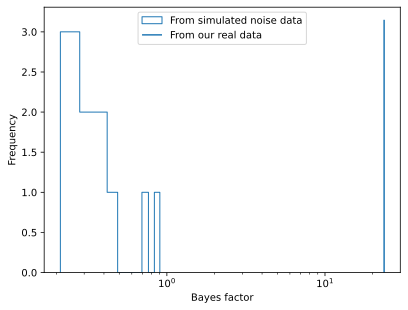

In [16]:
plt.figure()
plt.hist(np.exp(K_simulated), histtype='step', label='From simulated noise data')
ylo, yhi = plt.ylim()
plt.vlines(K, ylo, yhi, label='From our real data')
plt.xscale('log')
plt.xlabel('Bayes factor')
plt.ylabel('Frequency')
plt.legend(loc='upper center');

If we run this a bit longer, we will fill in the simulation histogram better. But already now we can see:

We are using simulations to measure how often, by chance, we would see a Bayes factor higher than the one we observe. By building up a histogram, we can get a p-value, telling us our false decision rate for any Bayes factor threshold. 
Thus, we are putting a frequentist property on our Bayesian inference-based decision. 

So I would say: 
**Pure noise does not produce as high a Bayes factor as we see it in the real data.**

Calibrating Bayes factor thresholds reduces the dependence on model priors and model parameter priors.


### Further reading

* Buchner+14 https://arxiv.org/abs/1402.0004 (§5.2, Appendix C for calibration)
* Trotta+08 https://arxiv.org/abs/0803.4089
* https://en.wikipedia.org/wiki/Bayes_factor
